In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.models import Sequential
from keras.layers import LSTM, Dense, SimpleRNN, Dropout
from keras.optimizers import SGD
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
ts_data = pd.read_csv("^FCHI.csv")
print(len(ts_data))
ts_data

8694


,Date,Open,High,Low,Close,Adj Close,Volume
0,1990-03-01,1836.000000,1838.000000,1827.000000,1832.000000,1832.000000,0.0
1,1990-03-02,1831.000000,1860.000000,1831.000000,1860.000000,1860.000000,0.0
2,1990-03-05,1866.000000,1874.000000,1862.000000,1874.000000,1874.000000,0.0
3,1990-03-06,1869.000000,1875.000000,1866.000000,1872.000000,1872.000000,0.0
4,1990-03-07,1874.000000,1881.000000,1874.000000,1880.000000,1880.000000,0.0
...,...,...,...,...,...,...,...
8689,2023-10-23,6820.250000,6855.930176,6773.819824,6850.470215,6850.470215,53038700.0
8690,2023-10-24,6865.100098,6909.080078,6833.910156,6893.649902,6893.649902,58807000.0
8691,2023-10-25,6859.689941,6927.270020,6846.509766,6915.069824,6915.069824,69113800.0
8692,2023-10-26,6835.529785,6915.240234,6825.589844,6888.959961,6888.959961,71582200.0


In [ ]:
ts_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
8689,2023-10-23,6820.250000,6855.930176,6773.819824,6850.470215,6850.470215,53038700.0
8690,2023-10-24,6865.100098,6909.080078,6833.910156,6893.649902,6893.649902,58807000.0
8691,2023-10-25,6859.689941,6927.270020,6846.509766,6915.069824,6915.069824,69113800.0
8692,2023-10-26,6835.529785,6915.240234,6825.589844,6888.959961,6888.959961,71582200.0
8693,2023-10-27,6898.979980,6898.979980,6784.620117,6795.379883,6795.379883,68755200.0


In [ ]:
ts_close = ts_data[['Date', 'Close']]
ts_close['Date'] = pd.to_datetime(ts_data['Date'], format='%Y-%m-%d')
ts_close = ts_close.set_index("Date")

<ipython-input-5-b752f6c07715>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts_close['Date'] = pd.to_datetime(ts_data['Date'], format='%Y-%m-%d')


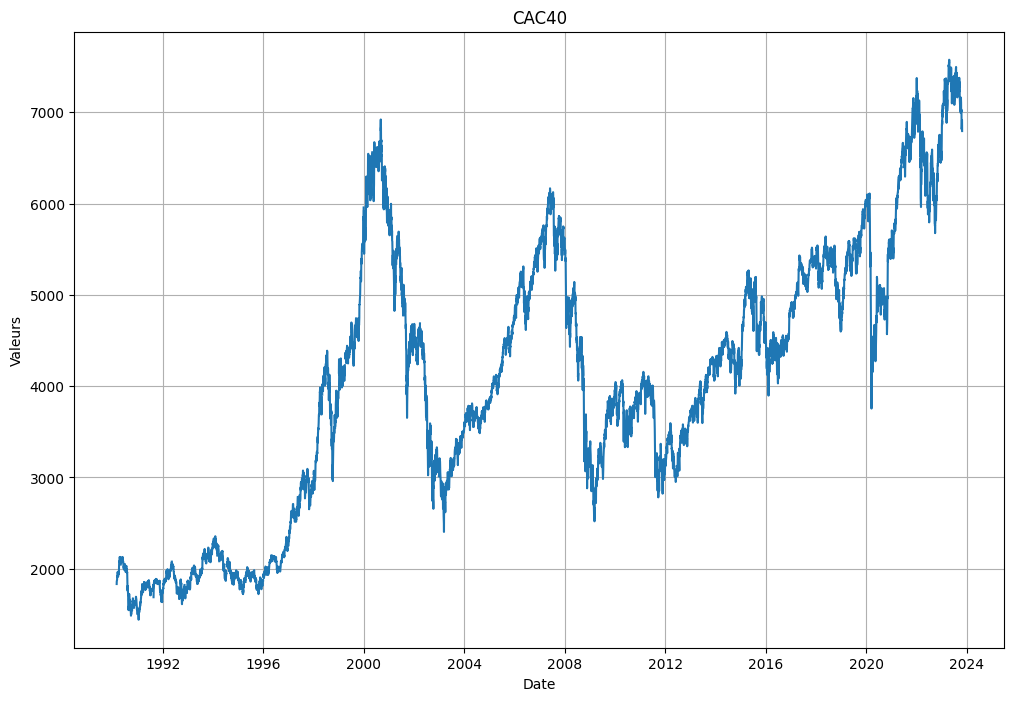

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(ts_close['Close'])
plt.title('CAC40')
plt.xlabel('Date')
plt.ylabel('Valeurs')
plt.grid(True)
plt.show()

In [ ]:
ts_close = ts_close.values
ts_close = ts_close.astype('float32')
ts_close = ts_close.reshape(-1,1)

In [ ]:
print(len(ts_close))
print(ts_close.shape)

8694
(8694, 1)


In [ ]:
print(len(ts_close))
ts_close = np.array(ts_close[~np.isnan(ts_close)])
ts_close = ts_close.reshape(-1,1)
print(len(ts_close))
ts_close

8694
8547


array([[1832.  ],
       [1860.  ],
       [1874.  ],
       ...,
       [6915.07],
       [6888.96],
       [6795.38]], dtype=float32)

In [ ]:
train_size = int(len(ts_close)*0.80)
test_size = len(ts_close)-train_size

train_close = ts_close[0:train_size,:]
test_close = ts_close[train_size:len(ts_close),:]
print("Taille de l'ensemble d'apprentissage :", len(train_close))
print("Taille de l'ensemble de test :", len(test_close))


Taille de l'ensemble d'apprentissage : 6837
Taille de l'ensemble de test : 1710


In [ ]:
scaler = StandardScaler()
scaler.fit(train_close)
train_close = scaler.transform(train_close)
test_close = scaler.transform(test_close)


In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator
seq_size = 30
batch_size = 1
train_generator = TimeseriesGenerator(train_close, train_close, length = seq_size, stride = 1, batch_size = batch_size)
print("Taille de l'ensemble d'apprentissage :", len(train_close))
print("Taille de l'ensemble train_generator :", len(train_generator))

Taille de l'ensemble d'apprentissage : 6837
Taille de l'ensemble train_generator : 6807


In [ ]:
#visualisation de ce qui est produit
x_0, y_0 = train_generator[0]
print("première sequence")
print(x_0)
print(y_0)

x_1, y_1 = train_generator[0] # on déplace la série temporelle de 1 à chaque fois
print("seconde sequence")
print(x_1)
print(y_1)

première sequence
[[[-1.4181143]
  [-1.3960683]
  [-1.3850453]
  [-1.38662  ]
  [-1.3803213]
  [-1.351189 ]
  [-1.3480396]
  [-1.3551259]
  [-1.3456776]
  [-1.3283558]
  [-1.3141834]
  [-1.3189075]
  [-1.3362293]
  [-1.3448902]
  [-1.3346546]
  [-1.3535511]
  [-1.335442 ]
  [-1.3141834]
  [-1.3283558]
  [-1.3338673]
  [-1.3275684]
  [-1.3078846]
  [-1.3275684]
  [-1.2976489]
  [-1.2850512]
  [-1.2637926]
  [-1.2307237]
  [-1.2204881]
  [-1.226787 ]
  [-1.204741 ]]]
[[-1.1937181]]
seconde sequence
[[[-1.4181143]
  [-1.3960683]
  [-1.3850453]
  [-1.38662  ]
  [-1.3803213]
  [-1.351189 ]
  [-1.3480396]
  [-1.3551259]
  [-1.3456776]
  [-1.3283558]
  [-1.3141834]
  [-1.3189075]
  [-1.3362293]
  [-1.3448902]
  [-1.3346546]
  [-1.3535511]
  [-1.335442 ]
  [-1.3141834]
  [-1.3283558]
  [-1.3338673]
  [-1.3275684]
  [-1.3078846]
  [-1.3275684]
  [-1.2976489]
  [-1.2850512]
  [-1.2637926]
  [-1.2307237]
  [-1.2204881]
  [-1.226787 ]
  [-1.204741 ]]]
[[-1.1937181]]


In [ ]:
val_generator = TimeseriesGenerator(test_close, test_close, length = seq_size, stride = 1, batch_size = batch_size)
print("Taille de l'échantillon de validation :", len(test_close))
print("Taille de l'échantillon de test :", len(val_generator))

Taille de l'échantillon de validation : 1710
Taille de l'échantillon de test : 1680


**MODELE LSTM**

In [ ]:
# Création du modèle LSTM
num_features = 1
model = Sequential()
model.add(LSTM(units=50, activation = 'relu', return_sequences=True, input_shape=(seq_size, num_features)))
model.add(LSTM(units=50, activation = 'relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30651 (119.73 KB)
Trainable params: 30651 (119.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Entrainement du modèle et prédictions

history = model.fit_generator(generator = train_generator, verbose = 2, epochs = 10, validation_data = val_generator)

train_pred = model.predict(train_generator)

test_pred = model.predict(val_generator)



Epoch 1/10


<ipython-input-16-73a9f081991d>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator = train_generator, verbose = 2, epochs = 10, validation_data = val_generator)


6807/6807 - 167s - loss: 0.1456 - val_loss: 0.0202 - 167s/epoch - 24ms/step
Epoch 2/10
6807/6807 - 160s - loss: 0.0047 - val_loss: 0.0047 - 160s/epoch - 23ms/step
Epoch 3/10
6807/6807 - 156s - loss: 0.0036 - val_loss: 0.0080 - 156s/epoch - 23ms/step
Epoch 4/10
6807/6807 - 153s - loss: 0.0030 - val_loss: 0.0129 - 153s/epoch - 22ms/step
Epoch 5/10
6807/6807 - 158s - loss: 0.0030 - val_loss: 0.0200 - 158s/epoch - 23ms/step
Epoch 6/10
6807/6807 - 154s - loss: 0.0028 - val_loss: 0.0037 - 154s/epoch - 23ms/step
Epoch 7/10
6807/6807 - 154s - loss: 0.0026 - val_loss: 0.0029 - 154s/epoch - 23ms/step
Epoch 8/10
6807/6807 - 154s - loss: 0.0025 - val_loss: 0.0038 - 154s/epoch - 23ms/step
Epoch 9/10
6807/6807 - 154s - loss: 0.0025 - val_loss: 0.0085 - 154s/epoch - 23ms/step
Epoch 10/10
6807/6807 - 153s - loss: 0.0024 - val_loss: 0.0031 - 153s/epoch - 22ms/step
1680/1680 [==============================] - 9s 5ms/step


In [ ]:
train_pred = scaler.inverse_transform(train_pred)
y_train_rescaled = scaler.inverse_transform(train_close)
test_pred = scaler.inverse_transform(test_pred)
y_test_rescaled = scaler.inverse_transform(test_close)

In [ ]:
print(len(train_close))
print(len(train_pred))

6837
6807


In [ ]:
train_score = math.sqrt(mean_squared_error(y_train_rescaled[seq_size:], train_pred))
print(f"score dur l'échantillon d'entrainement : {train_score} RMSE")

test_score = math.sqrt(mean_squared_error(y_test_rescaled[seq_size:], test_pred))
print(f"score dur l'échantillon de test : {test_score} RMSE")

score dur l'échantillon d'entrainement : 77.60361017697566 RMSE
score dur l'échantillon de test : 70.50877466448769 RMSE


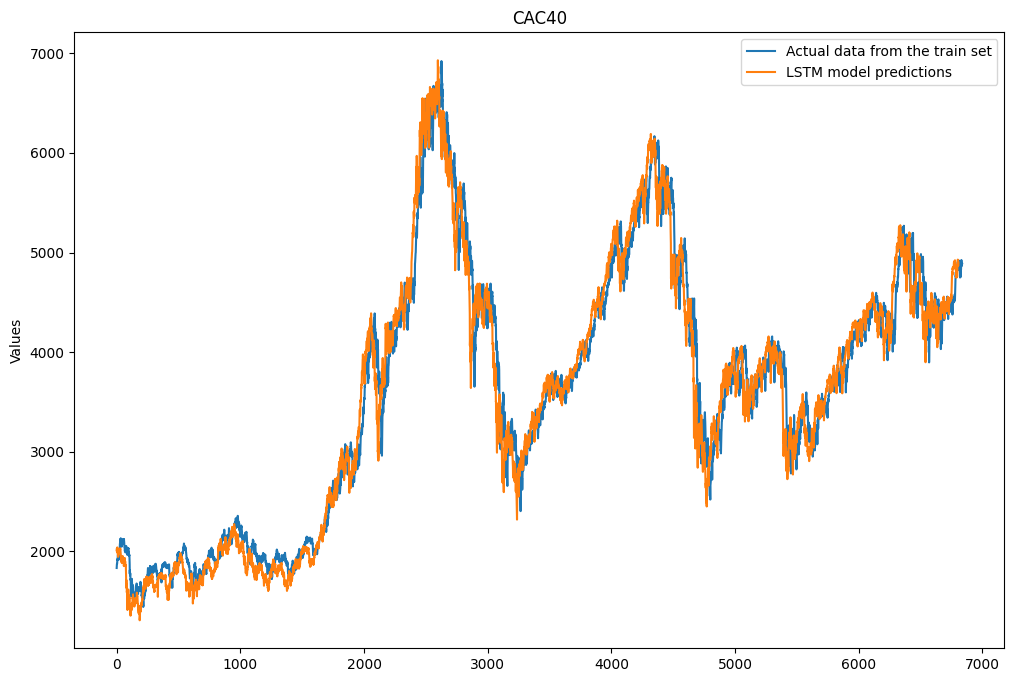

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(y_train_rescaled, label="Actual data from the train set")
plt.plot(train_pred, label='LSTM model predictions')
plt.title('CAC40')
plt.ylabel('Values')
plt.plot()
plt.legend()
plt.show()

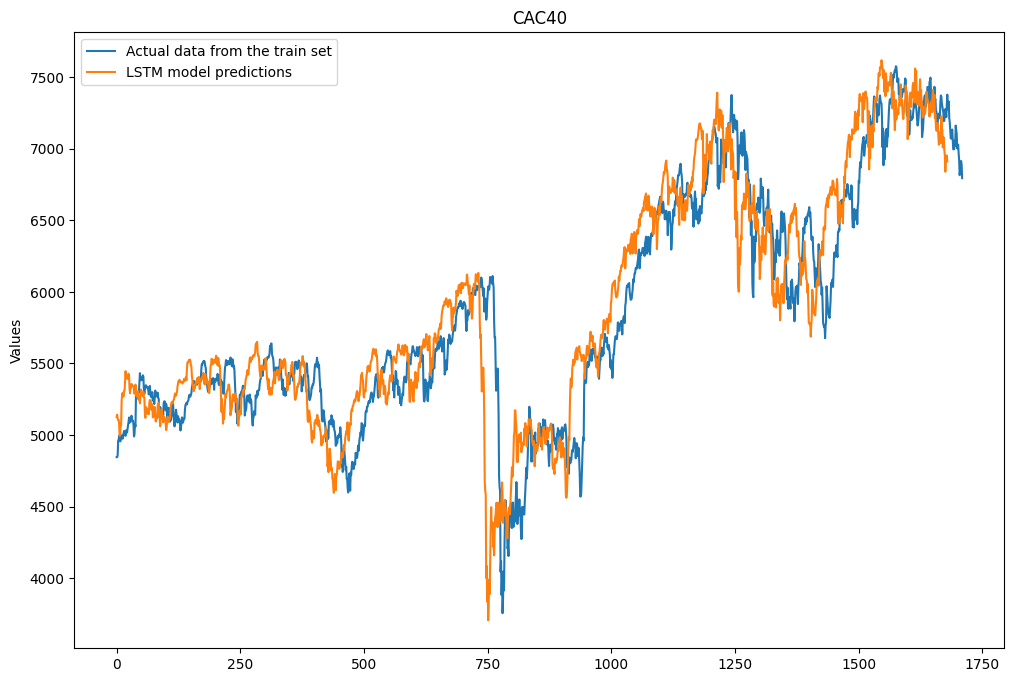

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(y_test_rescaled, label="Actual data from the train set")
plt.plot(test_pred, label='LSTM model predictions')
plt.title('CAC40')
plt.ylabel('Values')
plt.plot()
plt.legend()
plt.show()

*Prédictions futures*

In [ ]:
future_data = pd.read_csv("^FCHI_future.csv")
print(len(future_data))
future_data

25


,Date,Open,High,Low,Close,Adj Close,Volume
0,2023-10-27,6898.979980,6898.979980,6784.620117,6795.379883,6795.379883,68755200
1,2023-10-30,6826.950195,6854.600098,6809.839844,6825.069824,6825.069824,59561000
2,2023-10-31,6840.729980,6903.200195,6831.669922,6885.649902,6885.649902,66344100
3,2023-11-01,6914.319824,6954.839844,6873.549805,6932.629883,6932.629883,50434500
4,2023-11-02,6991.450195,7097.390137,6982.040039,7060.689941,7060.689941,67508200
5,2023-11-03,7084.509766,7086.709961,7046.859863,7047.500000,7047.500000,67586800
6,2023-11-06,7066.180176,7069.660156,7006.529785,7013.729980,7013.729980,49088200
7,2023-11-07,6970.660156,7011.790039,6963.879883,6986.229980,6986.229980,55272500
8,2023-11-08,6951.479980,7068.040039,6950.950195,7034.160156,7034.160156,52404100
9,2023-11-09,7043.879883,7122.509766,7025.609863,7113.660156,7113.660156,54999000


In [ ]:
f_close = future_data["Close"][1:21]
print(len(f_close))
f_close

20


1     6825.069824
2     6885.649902
3     6932.629883
4     7060.689941
5     7047.500000
6     7013.729980
7     6986.229980
8     7034.160156
9     7113.660156
10    7045.040039
11    7087.060059
12    7185.680176
13    7209.609863
14    7168.399902
15    7233.910156
16    7246.930176
17    7229.450195
18    7260.729980
19    7277.930176
20    7292.799805
Name: Close, dtype: float64

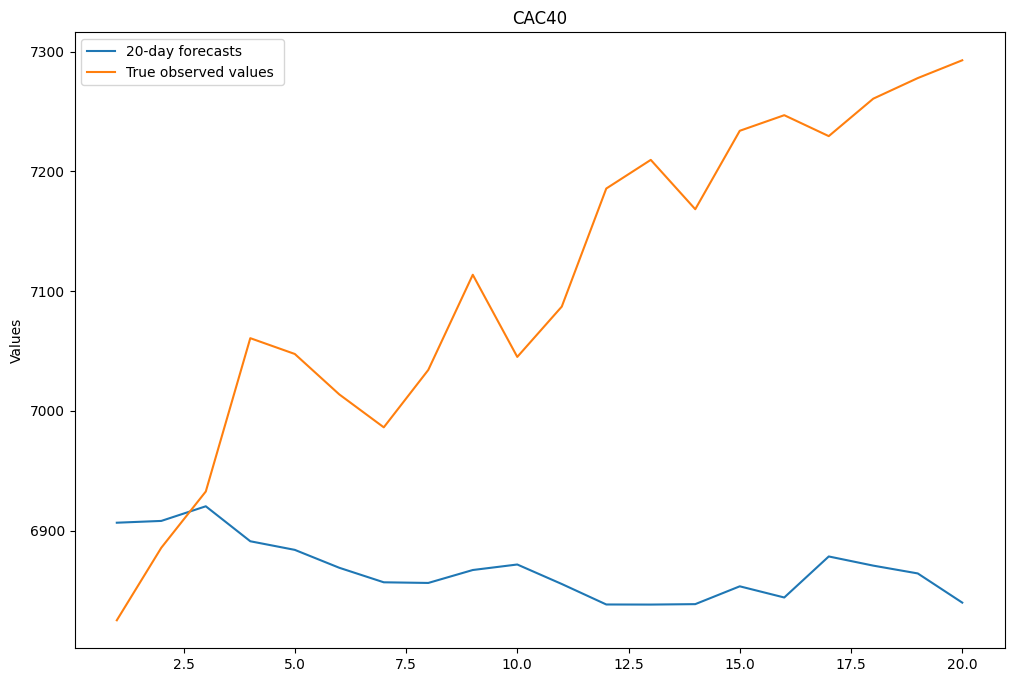

In [ ]:
# Sélectionnez les dernières séquences de test comme points de départ
test_pred_scaled =scaler.fit_transform(test_pred)
ts_close_rescaled = scaler.inverse_transform(ts_close)
starting_points = np.array(test_close[-seq_size:])

# Liste pour stocker les prédictions successives
future_predictions = []

# Génération des prédictions successives
#for i in range(100):
predictions = model.predict(starting_points.reshape(seq_size, 1), verbose=0)[:20]
future_predictions.extend(predictions)

# Inverse de la mise à l'échelle
future_predictions = np.array(future_predictions).reshape(-1,1)
future_predictions = scaler.inverse_transform(future_predictions)

# Comparaison graphique des résultats
plt.figure(figsize=(12, 8))
plt.plot(range(1,21), future_predictions, label='20-day forecasts')
plt.plot(range(1,21), f_close, label='True observed values ')
plt.title('CAC40')
plt.ylabel('Values')
plt.legend()
plt.show()


In [ ]:
f_score = math.sqrt(mean_squared_error(f_close, future_predictions))
print(f"score avec les prévisions : {f_score} RMSE")

score avec les prévisions : 283.10786831540975 RMSE


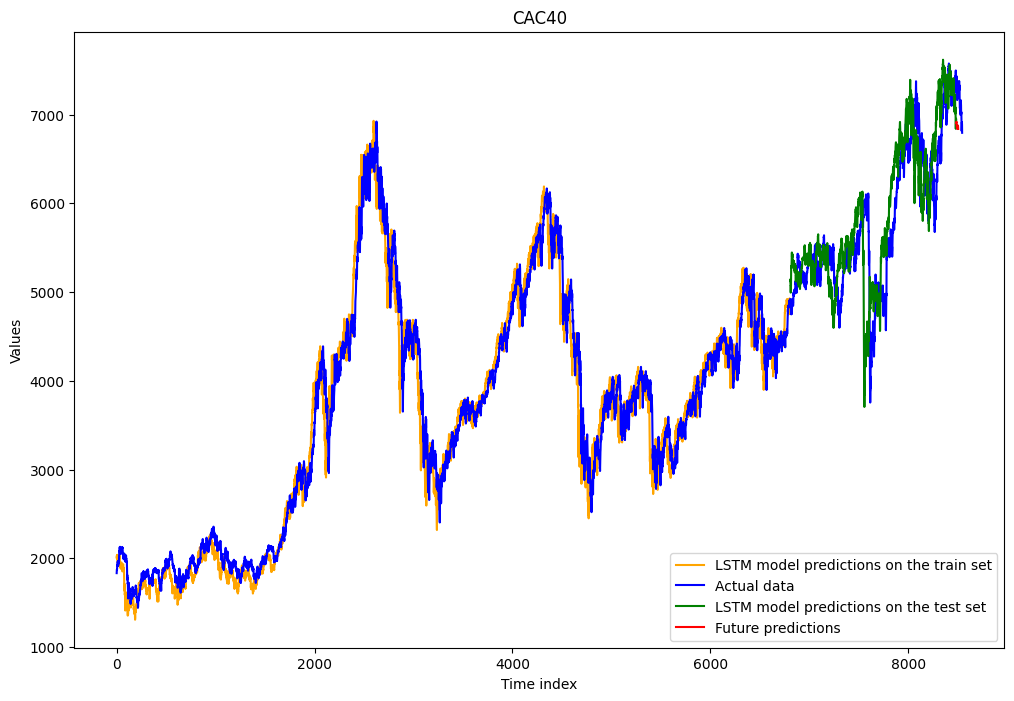

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(train_pred, label='LSTM model predictions on the train set', color='orange')
plt.plot(y_train_rescaled, label='Actual data', color='blue')
plt.plot(np.arange(len(y_train_rescaled), len(y_train_rescaled) + len(y_test_rescaled)), y_test_rescaled, color='blue')

# Plot des prédictions sur l'échantillon de test
plt.plot(np.arange(len(train_pred), len(train_pred) + len(test_pred)), test_pred, label='LSTM model predictions on the test set', color='green')

# Plot des prévisions futures
plt.plot(np.arange(len(train_pred) + len(test_pred), len(train_pred) + len(test_pred) + len(future_predictions)), future_predictions, label='Future predictions', color='red')

# Ajout des labels et de la légende
plt.xlabel('Time index')
plt.ylabel('Values')
plt.title('CAC40')
plt.legend()
plt.show()

### MODELE LSTM sur les rendements

In [ ]:
returns_close = ts_data['Close'].pct_change()

In [ ]:
returns_close = returns_close.values
returns_close = returns_close.astype('float32')
returns_close = returns_close.reshape(-1,1)

In [ ]:
print(len(returns_close))
returns_close = np.array(returns_close[~np.isnan(returns_close)])
returns_close = returns_close.reshape(-1,1)
print(len(returns_close))
returns_close

8694
8693


array([[ 0.01528384],
       [ 0.00752688],
       [-0.00106724],
       ...,
       [ 0.0031072 ],
       [-0.00377579],
       [-0.01358406]], dtype=float32)

In [ ]:
train_returns = returns_close[0:train_size,:]
test_returns = returns_close[train_size:len(returns_close),:]
print("Taille de l'ensemble d'apprentissage :", len(train_returns))
print("Taille de l'ensemble de test :", len(test_returns))

Taille de l'ensemble d'apprentissage : 6837
Taille de l'ensemble de test : 1856


In [ ]:
scaler_r = StandardScaler()
scaler_r.fit(train_returns)
train_returns = scaler_r.transform(train_returns)
test_returns = scaler_r.transform(test_returns)

In [ ]:
train_generator_r = TimeseriesGenerator(train_returns, train_returns, length = seq_size, stride = 1, batch_size = batch_size)
print("Taille de l'ensemble d'apprentissage :", len(train_returns))
print("Taille de l'ensemble dans train_generator :", len(train_generator_r))

Taille de l'ensemble d'apprentissage : 6837
Taille de l'ensemble dans train_generator : 6807


In [ ]:
val_generator_r = TimeseriesGenerator(test_returns, test_returns, length = seq_size, stride = 1, batch_size = batch_size)
print("Taille de l'échantillon de validation :", len(test_returns))
print("Taille de l'échantillon de test :", len(val_generator_r))

Taille de l'échantillon de validation : 1856
Taille de l'échantillon de test : 1826


In [ ]:
# Création du modèle LSTM
num_features = 1
model2 = Sequential()
model2.add(LSTM(units=50, activation = 'relu', return_sequences=True, input_shape=(seq_size, num_features)))
model2.add(LSTM(units=50, activation = 'relu'))
model2.add(Dense(1))
model2.compile(optimizer='adam', loss='mean_squared_error')

model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 30, 50)            10400     
                                                                 
 lstm_7 (LSTM)               (None, 50)                20200     
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 30651 (119.73 KB)
Trainable params: 30651 (119.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history_r = model2.fit_generator(generator = train_generator_r, verbose = 2, epochs = 10, validation_data = val_generator_r)

train_pred_r = model2.predict(train_generator_r)

test_pred_r = model2.predict(val_generator_r)

Epoch 1/10


<ipython-input-66-fe52b7a69cc4>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_r = model2.fit_generator(generator = train_generator_r, verbose = 2, epochs = 10, validation_data = val_generator_r)


6807/6807 - 162s - loss: 1.0036 - val_loss: 0.6973 - 162s/epoch - 24ms/step
Epoch 2/10
6807/6807 - 164s - loss: 1.0022 - val_loss: 0.6991 - 164s/epoch - 24ms/step
Epoch 3/10
6807/6807 - 163s - loss: 1.0004 - val_loss: 0.7007 - 163s/epoch - 24ms/step
Epoch 4/10
6807/6807 - 176s - loss: 0.9977 - val_loss: 0.7039 - 176s/epoch - 26ms/step
Epoch 5/10
6807/6807 - 163s - loss: 1.1147 - val_loss: 0.7270 - 163s/epoch - 24ms/step
Epoch 6/10
6807/6807 - 162s - loss: 0.9881 - val_loss: 0.7087 - 162s/epoch - 24ms/step
Epoch 7/10
6807/6807 - 162s - loss: 0.9921 - val_loss: 0.7076 - 162s/epoch - 24ms/step
Epoch 8/10
6807/6807 - 160s - loss: 0.9908 - val_loss: 0.7068 - 160s/epoch - 23ms/step
Epoch 9/10
6807/6807 - 157s - loss: 10.3578 - val_loss: 0.7098 - 157s/epoch - 23ms/step
Epoch 10/10
6807/6807 - 157s - loss: 0.9848 - val_loss: 0.7217 - 157s/epoch - 23ms/step
1826/1826 [==============================] - 9s 5ms/step


In [ ]:
train_pred_r = scaler_r.inverse_transform(train_pred_r)
train_returns_rescaled = scaler_r.inverse_transform(train_returns)
test_pred_r = scaler_r.inverse_transform(test_pred_r)
test_returns_rescaled = scaler_r.inverse_transform(test_returns)

In [ ]:
train_r_score = math.sqrt(mean_squared_error(train_returns_rescaled[seq_size:], train_pred_r))
print(f"score dur l'échantillon d'entrainement : {train_r_score} RMSE")

test_r_score = math.sqrt(mean_squared_error(test_returns_rescaled[seq_size:], test_pred_r))
print(f"score dur l'échantillon de test : {test_r_score} RMSE")

score dur l'échantillon d'entrainement : 0.013771848576593186 RMSE
score dur l'échantillon de test : 0.011840740429716924 RMSE


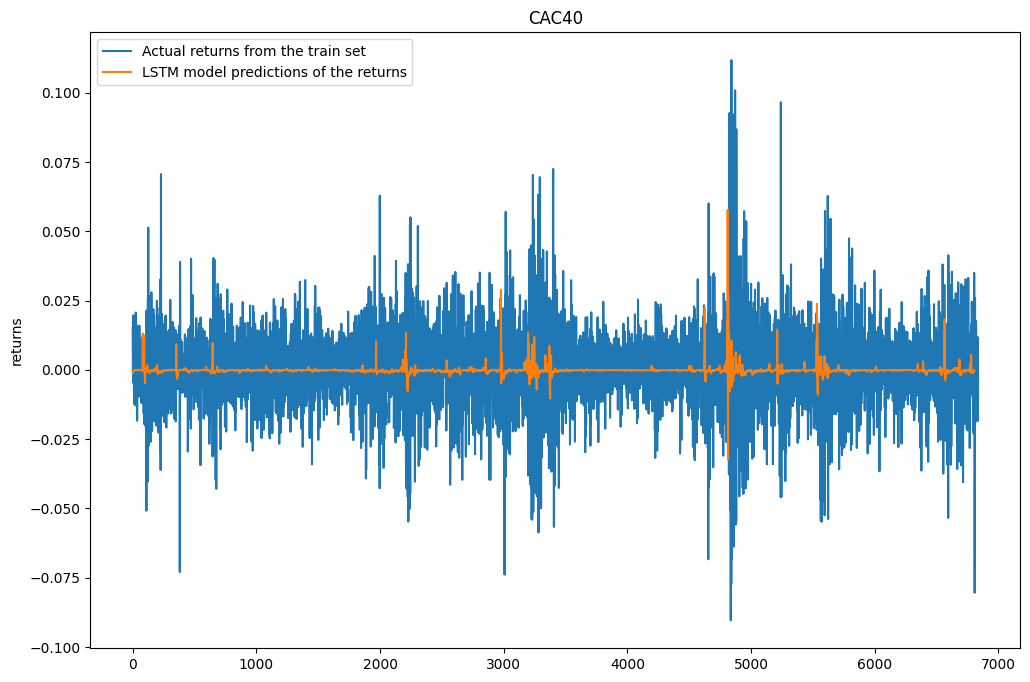

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(train_returns_rescaled, label="Actual returns from the train set")
plt.plot(train_pred_r, label='LSTM model predictions of the returns')
plt.title('CAC40')
plt.ylabel('returns')
plt.plot()
plt.legend()
plt.show()

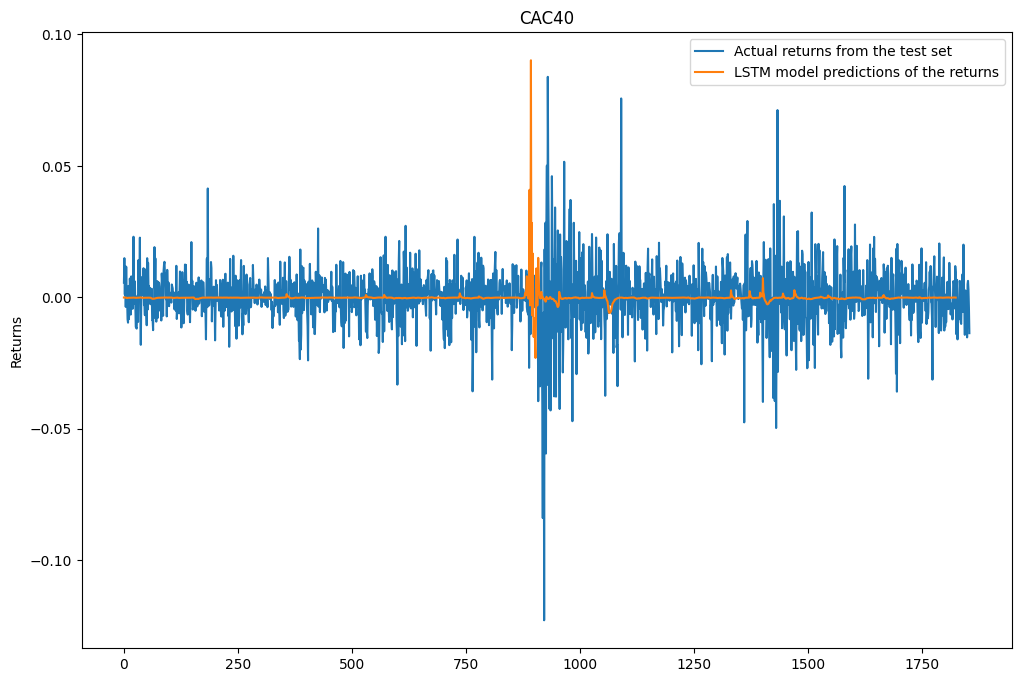

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(test_returns_rescaled, label="Actual returns from the test set")
plt.plot(test_pred_r, label='LSTM model predictions of the returns')
plt.title('CAC40')
plt.ylabel('Returns')
plt.plot()
plt.legend()
plt.show()

In [ ]:
f_returns = future_data["Close"].pct_change()[1:21]
f_returns


1     0.004369
2     0.008876
3     0.006823
4     0.018472
5    -0.001868
6    -0.004792
7    -0.003921
8     0.006861
9     0.011302
10   -0.009646
11    0.005964
12    0.013916
13    0.003330
14   -0.005716
15    0.009139
16    0.001800
17   -0.002412
18    0.004327
19    0.002369
20    0.002043
Name: Close, dtype: float64

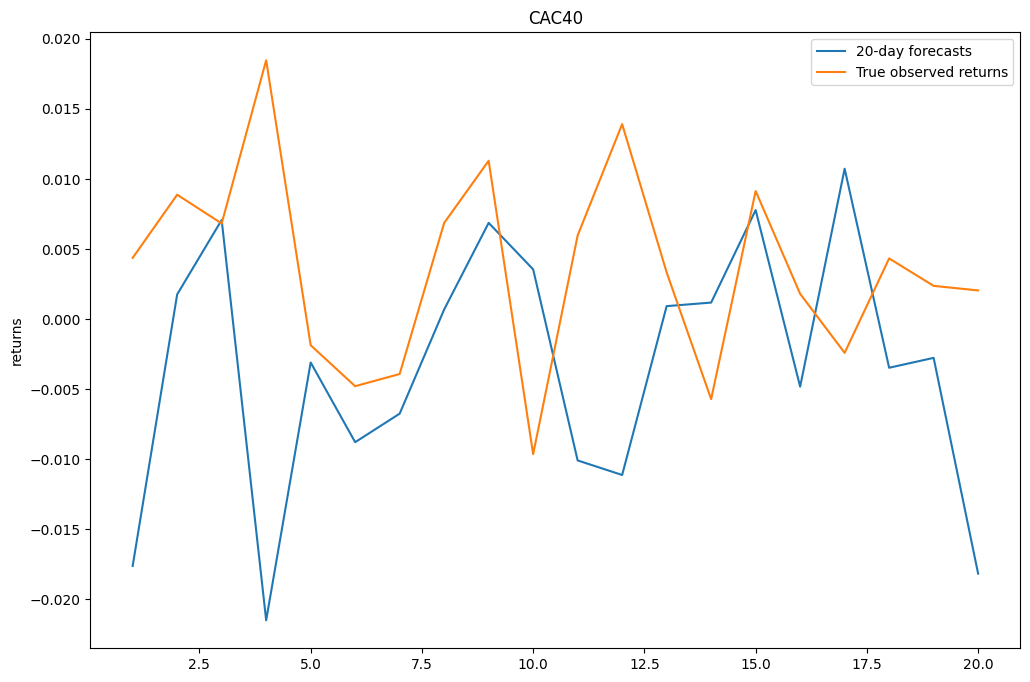

In [ ]:
# Sélectionnez les dernières séquences de test comme points de départ
test_pred_r_scaled =scaler_r.transform(test_pred_r)
starting_points_r = np.array(test_returns[-seq_size:])

# Liste pour stocker les prédictions successives
future_predictions_r = []

# Génération des prédictions successives
#for i in range(100):
predictions_r = model.predict(starting_points_r.reshape(seq_size, 1), verbose=0)[:20]
future_predictions_r.extend(predictions_r)

# Inverse de la mise à l'échelle
future_predictions_r = np.array(future_predictions_r).reshape(-1,1)
future_predictions_r = scaler_r.inverse_transform(future_predictions_r)

# Comparaison graphique des résultats
plt.figure(figsize=(12, 8))
plt.plot(range(1,21), future_predictions_r, label='20-day forecasts')
plt.plot(range(1,21), f_returns, label='True observed returns')
plt.title('CAC40')
plt.ylabel('returns')
plt.legend()
plt.show()

In [ ]:
f_score_r = math.sqrt(mean_squared_error(f_returns[1:], future_predictions_r[1:]))
print(f"score avec les prévisions : {f_score_r} RMSE")

score avec les prévisions : 0.0136864356441864 RMSE


**MODELE CNN**

In [ ]:
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

In [ ]:
seq_sizeCNN = 10
train_generatorCNN = TimeseriesGenerator(train_close, train_close, length = seq_sizeCNN, stride = 1, batch_size = batch_size)
val_generatorCNN = TimeseriesGenerator(test_close, test_close, length = seq_sizeCNN, stride = 1, batch_size = batch_size)

In [ ]:
# Création du modèle CNN
modelCNN = Sequential()
modelCNN.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(seq_sizeCNN, num_features)))
modelCNN.add(MaxPooling1D(pool_size=2))
modelCNN.add(Flatten())
modelCNN.add(Dense(50, activation='relu'))
modelCNN.add(Dense(1))
modelCNN.compile(optimizer='adam', loss='mean_squared_error')

modelCNN.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 9, 64)             192       
                                                                 
 max_pooling1d (MaxPooling1  (None, 4, 64)             0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 50)                12850     
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 13093 (51.14 KB)
Trainable params: 13093 (51.14 KB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [ ]:
# Entrainement du modèle et prédictions

historyCNN = modelCNN.fit_generator(generator = train_generatorCNN, verbose = 2, epochs = 10, validation_data = val_generatorCNN)

train_predCNN = modelCNN.predict(train_generatorCNN)

test_predCNN = modelCNN.predict(val_generatorCNN)

<ipython-input-87-2f80ff5eadba>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  historyCNN = modelCNN.fit_generator(generator = train_generatorCNN, verbose = 2, epochs = 10, validation_data = val_generatorCNN)


Epoch 1/10
6827/6827 - 19s - loss: 0.0048 - val_loss: 0.0065 - 19s/epoch - 3ms/step
Epoch 2/10
6827/6827 - 19s - loss: 0.0046 - val_loss: 0.0077 - 19s/epoch - 3ms/step
Epoch 3/10
6827/6827 - 21s - loss: 0.0046 - val_loss: 0.0086 - 21s/epoch - 3ms/step
Epoch 4/10
6827/6827 - 18s - loss: 0.0046 - val_loss: 0.0093 - 18s/epoch - 3ms/step
Epoch 5/10
6827/6827 - 20s - loss: 0.0044 - val_loss: 0.0157 - 20s/epoch - 3ms/step
Epoch 6/10
6827/6827 - 20s - loss: 0.0045 - val_loss: 0.0068 - 20s/epoch - 3ms/step
Epoch 7/10
6827/6827 - 21s - loss: 0.0044 - val_loss: 0.0123 - 21s/epoch - 3ms/step
Epoch 8/10
6827/6827 - 21s - loss: 0.0043 - val_loss: 0.0083 - 21s/epoch - 3ms/step
Epoch 9/10
6827/6827 - 18s - loss: 0.0045 - val_loss: 0.0081 - 18s/epoch - 3ms/step
Epoch 10/10
6827/6827 - 18s - loss: 0.0043 - val_loss: 0.0063 - 18s/epoch - 3ms/step
1700/1700 [==============================] - 3s 2ms/step


In [ ]:
train_predCNN = scaler.inverse_transform(train_predCNN)
test_predCNN = scaler.inverse_transform(test_predCNN)

In [ ]:
train_scoreCNN = math.sqrt(mean_squared_error(y_train_rescaled[seq_sizeCNN:], train_predCNN))
print(f"score dur l'échantillon d'entrainement : {train_scoreCNN} RMSE")

test_scoreCNN = math.sqrt(mean_squared_error(y_test_rescaled[seq_sizeCNN:], test_predCNN))
print(f"score dur l'échantillon de test : {test_scoreCNN} RMSE")

score dur l'échantillon d'entrainement : 2301.3891457117807 RMSE
score dur l'échantillon de test : 1503.02445089892 RMSE


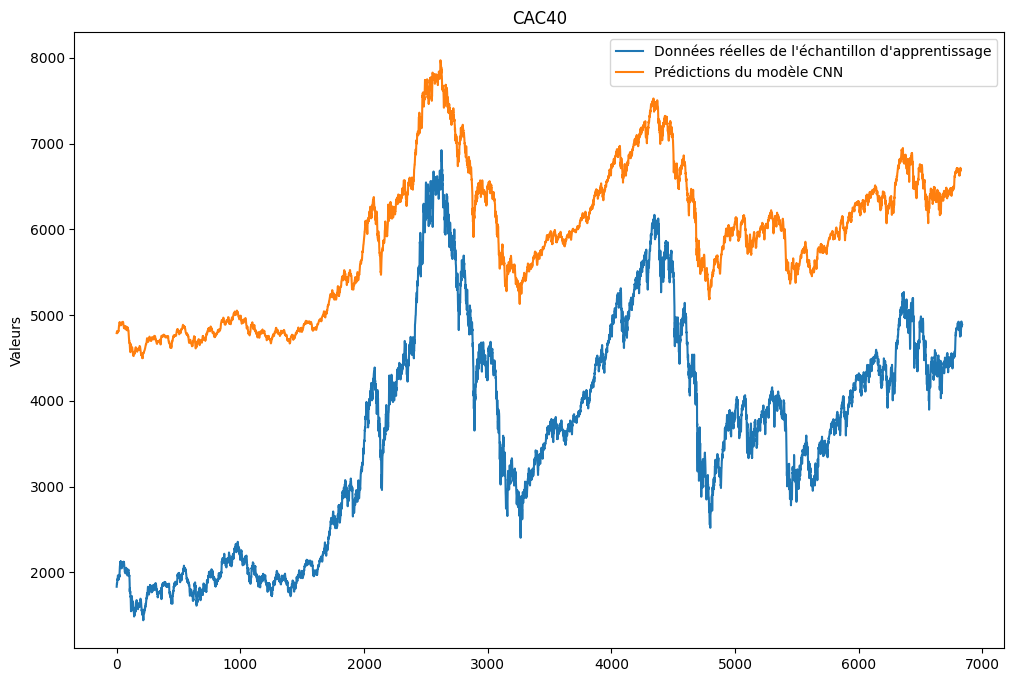

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(y_train_rescaled, label="Données réelles de l'échantillon d'apprentissage")
plt.plot(train_predCNN, label='Prédictions du modèle CNN')
plt.title('CAC40')
plt.ylabel('Valeurs')
plt.plot()
plt.legend()
plt.show()

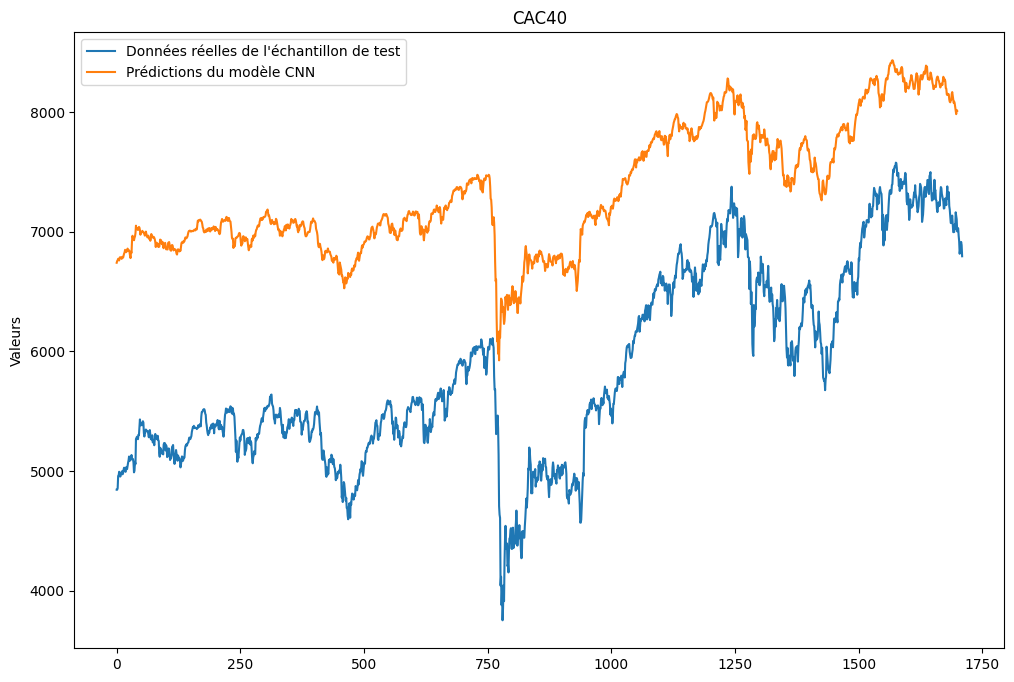

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(y_test_rescaled, label="Données réelles de l'échantillon de test")
plt.plot(test_predCNN, label='Prédictions du modèle CNN')
plt.title('CAC40')
plt.ylabel('Valeurs')
plt.plot()
plt.legend()
plt.show()

**Prévisions**

1/1 [==============================] - 0s 31ms/step


<ipython-input-92-8fb9778457c1>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  future_predictionsCNN = np.array(future_predictionsCNN).reshape(-1,1)


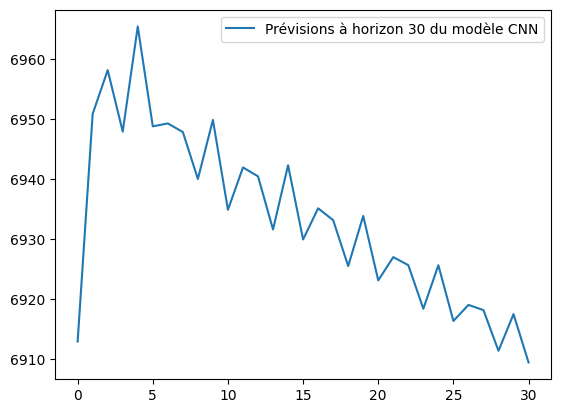

In [ ]:
# Sélectionnez les dernières séquences de test comme points de départ
starting_points = np.array(test_pred_scaled[-seq_sizeCNN:])

# Liste pour stocker les prédictions successives
future_predictionsCNN = [starting_points[-1,:]]

# Génération des prédictions successives
for i in range(30):
  predictionCNN = modelCNN.predict(starting_points.reshape(1, seq_sizeCNN, 1))
  future_predictionsCNN.append(predictionCNN)
#Mise à jour des points de départ pour inclure la nouvelle prédiction
  starting_points = np.append(starting_points[-seq_sizeCNN+1:,:], predictionCNN.reshape(1, 1), axis=0)

# Inverse de la mise à l'échelle
future_predictionsCNN = np.array(future_predictionsCNN).reshape(-1,1)
future_predictionsCNN = scaler.inverse_transform(future_predictionsCNN)

# Comparaison graphique des résultats
plt.plot(future_predictionsCNN, label='Prévisions à horizon 30 du modèle CNN')
plt.legend()
plt.show()

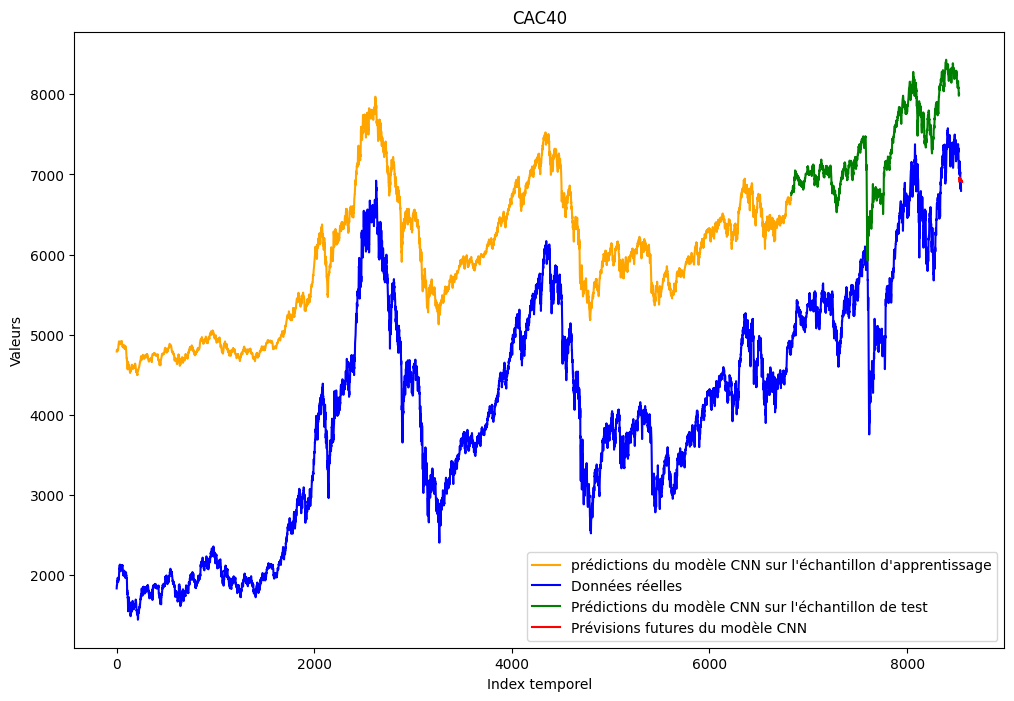

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(train_predCNN, label='prédictions du modèle CNN sur l\'échantillon d\'apprentissage', color='orange')
plt.plot(y_train_rescaled, label='Données réelles', color='blue')
plt.plot(np.arange(len(y_train_rescaled), len(y_train_rescaled) + len(y_test_rescaled)), y_test_rescaled, color='blue')

# Plot des prédictions sur l'échantillon de test
plt.plot(np.arange(len(train_predCNN), len(train_predCNN) + len(test_predCNN)), test_predCNN, label='Prédictions du modèle CNN sur l\'échantillon de test', color='green')

# Plot des prévisions futures
plt.plot(np.arange(len(train_predCNN) + len(test_predCNN), len(train_predCNN) + len(test_predCNN) + len(future_predictionsCNN)), future_predictionsCNN, label='Prévisions futures du modèle CNN', color='red')

# Ajout des labels et de la légende
plt.xlabel('Index temporel')
plt.ylabel('Valeurs')
plt.title('CAC40')
plt.legend()
plt.show()